In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
from scipy.optimize import curve_fit
import uncertainties.unumpy as un

rho, g = 997, 9.8067

class bomba:

    def __init__(self, pe, ps, ve, vs, ze, zs):
        self.pe = pe
        self.ps = ps
        self.ve = ve
        self.vs = vs
        self.ze = ze
        self.zs = zs

    @property
    def hm(self):
        return (self.ps-self.pe)/(rho*g)
    @property
    def hu(self):
        A = (self.ps - self.pe)/(rho*g)
        B = ((self.vs**2) - (self.ve**2))/(2*g)
        return A + B + (self.zs - self.ze)

    def ph(self, Q):
        return Q*rho*g*self.hu

    def psi_m(self, w, D):
        C_psi = 8
        return C_psi*((g*self.hm)/((D**2)*(w**2)))

    def psi_u(self, w, D):
        C_psi = 8
        return C_psi*((g*self.hu)/((D**2)*(w**2)))

    def nq_m(self, Q, w):
        Cnq = ((30*g)**(3/4))/np.pi
        return Cnq*(w*un.sqrt(Q)/(g*self.hm)**(3/4))

    def nq_u(self, Q, w):
        Cnq = ((30*g)**(3/4))/np.pi
        return Cnq*(w*un.sqrt(Q)/(g*self.hu)**(3/4))

    def phi(self, Q, w, D):
        C_phi = 63369.75
        return C_phi*(Q/(w*D**3))

    def Re(self, w, D, v):
        return (w*D**2)/(v)

def Q2v(Q, D):
    '''
    Q[m^3/h] e D[m]
    '''
    q = Q/3600 #m^3/s
    r = D/2    #m
    return q/(np.pi*(r**2))

def incert_A(array):
    return ufloat(array.mean(), array.std(ddof=1)/np.sqrt(len(array)))

#Info dos instrumentos
df_inst = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. TurboMaq/Lab 2 - Bombas Centrífugas valv. Sucção/dados.xlsx', sheet_name='instr')

#Info medidas -> var pressão descarga
df_desc = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. TurboMaq/Lab 2 - Bombas Centrífugas valv. Sucção/dados.xlsx', sheet_name='vazão1')

#Info medidas -> var pressão sucção
df_suc = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. TurboMaq/Lab 2 - Bombas Centrífugas valv. Sucção/dados.xlsx', sheet_name='vazão2')

#Incerteza do tipo B - a/raiz(3) - Val. descarga
d_pe = un.uarray(df_desc.pe.values, (df_desc.pe.values*0.05)/np.sqrt(3)) * 98066.5 #Pa
d_ps = un.uarray(df_desc.ps.values, (df_desc.ps.values*0.05)/np.sqrt(3)) * 98066.5 #Pa
d_Q = un.uarray(df_desc.Q.values, (df_desc.Q.values*0.02)/np.sqrt(3)) #m^3/h
d_w = un.uarray(df_desc.w.values, (df_desc.w.values*0.02)/np.sqrt(3)) * 0.016667 #Hz

#Incerteza do tipo B - a/raiz(3) - Val. sucção
s_pe = un.uarray(df_suc.pe.values, (df_suc.pe.values*0.05)/np.sqrt(3)) * 98066.5 #Pa
s_ps = un.uarray(df_suc.ps.values, (df_suc.ps.values*0.05)/np.sqrt(3)) * 98066.5 #Pa
s_Q = un.uarray(df_suc.Q.values, (df_suc.Q.values*0.02)/np.sqrt(3)) #m^3/h
s_w = un.uarray(df_suc.w.values, (df_suc.w.values*0.02)/np.sqrt(3)) * 0.016667 #Hz

#Incerteza do tipo A
ze = incert_A(df_inst.ze.values) / 100  #m
zs = incert_A(df_inst.zs.values) / 100
De = incert_A(df_inst.De.values) / 1000
Ds = incert_A(df_inst.Ds.values) / 1000
Drot = incert_A(df_inst.D.values) / 100

In [2]:
b1  = bomba(d_pe, d_ps, Q2v(d_Q, De), Q2v(d_Q, Ds), ze, zs)
b2  = bomba(s_pe, s_ps, Q2v(s_Q, De), Q2v(s_Q, Ds), ze, zs)

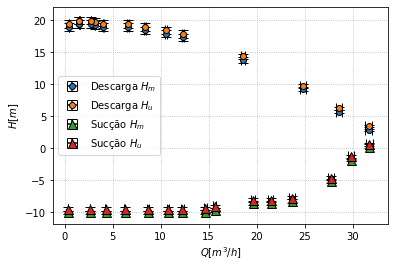

In [3]:
# Figura 1 
#%matplotlib
fig, ax = plt.subplots()
ax.set(ylabel=r'$H [m]$', xlabel=r'$Q [m^3/h]$')

#descarga
ax.errorbar(y=un.nominal_values(b1.hm), x=un.nominal_values(d_Q), yerr=un.std_devs(b1.hm), xerr=un.std_devs(d_Q), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'Descarga $H_m$')
ax.errorbar(y=un.nominal_values(b1.hu), x=un.nominal_values(d_Q), yerr=un.std_devs(b1.hu), xerr=un.std_devs(d_Q), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'Descarga $H_u$') 

#sucção
ax.errorbar(y=un.nominal_values(b2.hm), x=un.nominal_values(s_Q), yerr=un.std_devs(b2.hm), xerr=un.std_devs(s_Q), 
            fmt='^', capsize=5, markersize=9, markeredgecolor='black', ecolor='black', label=r'Sucção $H_m$')
ax.errorbar(y=un.nominal_values(b2.hu), x=un.nominal_values(s_Q), yerr=un.std_devs(b2.hu), xerr=un.std_devs(s_Q), 
            fmt='^', capsize=5, markersize=9, markeredgecolor='black', ecolor='black', label=r'Sucção $H_u$') 
ax.legend()
ax.grid(ls='dotted')
fig.savefig('H_x_Q.pdf', bbox_inches='tight')

In [23]:
tab = pd.DataFrame({'Q':d_Q, 'Hm':b2.hm, 'Hu':b2.hu})
print(tab.to_latex())

\begin{tabular}{llll}
\toprule
{} &              Q &           Hm &           Hu \\
\midrule
0  &     31.6+/-0.4 &  2.91+/-0.15 &  3.44+/-0.15 \\
1  &   28.55+/-0.33 &  5.72+/-0.22 &  6.25+/-0.22 \\
2  &   24.80+/-0.29 &  9.23+/-0.32 &  9.76+/-0.32 \\
3  &   18.57+/-0.21 &   13.8+/-0.5 &   14.4+/-0.5 \\
4  &   12.32+/-0.14 &   17.4+/-0.6 &   17.9+/-0.6 \\
5  &   10.57+/-0.12 &   18.0+/-0.6 &   18.5+/-0.6 \\
6  &    8.40+/-0.10 &   18.5+/-0.6 &   19.0+/-0.6 \\
7  &    6.58+/-0.08 &   19.0+/-0.6 &   19.5+/-0.6 \\
8  &    4.01+/-0.05 &   19.0+/-0.6 &   19.5+/-0.6 \\
9  &    3.17+/-0.04 &   19.3+/-0.6 &   19.8+/-0.6 \\
10 &  2.740+/-0.032 &   19.5+/-0.6 &   20.0+/-0.6 \\
11 &  1.550+/-0.018 &   19.5+/-0.6 &   20.0+/-0.6 \\
12 &  1.550+/-0.018 &   19.5+/-0.6 &   20.0+/-0.6 \\
13 &  0.500+/-0.006 &   19.0+/-0.6 &   19.5+/-0.6 \\
\bottomrule
\end{tabular}



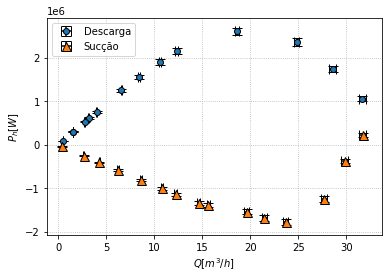

In [11]:
# Figura 2
fig, ax = plt.subplots()
ax.set(ylabel=r'$P_h[W]$', xlabel=r'$Q[m^3/h]$')

ax.errorbar(y=un.nominal_values(b1.ph(d_Q)), x=un.nominal_values(d_Q), yerr=un.std_devs(b1.ph(d_Q)), xerr=un.std_devs(d_Q), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label='Descarga')

ax.errorbar(y=un.nominal_values(b2.ph(s_Q)), x=un.nominal_values(s_Q), yerr=un.std_devs(b2.ph(s_Q)), xerr=un.std_devs(s_Q), 
            fmt='^', capsize=5,  markersize=9,markeredgecolor='black', ecolor='black', label='Sucção')        
ax.legend()
ax.grid(ls='dotted')
fig.savefig('P_x_Q.pdf', bbox_inches='tight')

In [ ]:
tab = pd.DataFrame({'Q':s_Q, 'Ph':b2.ph(s_Q)})
print(tab.to_latex())

\begin{tabular}{lll}
\toprule
{} &              Q &                 Ph \\
\midrule
0  &     31.6+/-0.4 &  (1.06+/-0.05)e+06 \\
1  &   28.55+/-0.33 &  (1.74+/-0.07)e+06 \\
2  &   24.80+/-0.29 &  (2.37+/-0.08)e+06 \\
3  &   18.57+/-0.21 &  (2.61+/-0.09)e+06 \\
4  &   12.32+/-0.14 &  (2.15+/-0.07)e+06 \\
5  &   10.57+/-0.12 &  (1.91+/-0.06)e+06 \\
6  &    8.40+/-0.10 &  (1.56+/-0.05)e+06 \\
7  &    6.58+/-0.08 &  (1.25+/-0.04)e+06 \\
8  &    4.01+/-0.05 &  (7.64+/-0.25)e+05 \\
9  &    3.17+/-0.04 &  (6.13+/-0.20)e+05 \\
10 &  2.740+/-0.032 &  (5.36+/-0.17)e+05 \\
11 &  1.550+/-0.018 &  (3.03+/-0.10)e+05 \\
12 &  1.550+/-0.018 &  (3.03+/-0.10)e+05 \\
13 &  0.500+/-0.006 &  (9.53+/-0.31)e+04 \\
\bottomrule
\end{tabular}



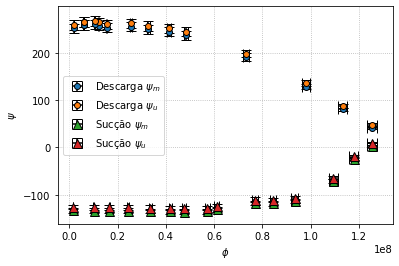

In [12]:
# Figura 3
fig, ax = plt.subplots()
ax.set(ylabel=r'$\psi$', xlabel=r'$\phi$')

#Descarga
ax.errorbar(y=un.nominal_values(b1.psi_m(d_w, De)), x=un.nominal_values(b1.phi(d_Q, d_w, De)), 
            yerr=un.std_devs(b1.psi_m(d_w, De)), xerr=un.std_devs(b1.phi(d_Q, d_w, De)), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'Descarga $\psi_{m}$')

ax.errorbar(y=un.nominal_values(b1.psi_u(d_w, De)), x=un.nominal_values(b1.phi(d_Q, d_w, De)), 
            yerr=un.std_devs(b1.psi_u(d_w, De)), xerr=un.std_devs(b1.phi(d_Q, d_w, De)), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'Descarga $\psi_{u}$')    

#Sucçao
ax.errorbar(y=un.nominal_values(b2.psi_m(s_w, De)), x=un.nominal_values(b2.phi(s_Q, s_w, De)), 
            yerr=un.std_devs(b2.psi_m(s_w, De)), xerr=un.std_devs(b2.phi(s_Q, s_w, De)), 
            fmt='^', capsize=5, markersize=9, markeredgecolor='black', ecolor='black', label=r'Sucção $\psi_{m}$')

ax.errorbar(y=un.nominal_values(b2.psi_u(s_w, De)), x=un.nominal_values(b2.phi(s_Q, s_w, De)), 
            yerr=un.std_devs(b2.psi_u(s_w, De)), xerr=un.std_devs(b2.phi(s_Q, s_w, De)), 
            fmt='^', capsize=5, markersize=9, markeredgecolor='black', ecolor='black', label=r'Sucção $\psi_{u}$')     
ax.legend()
ax.grid(ls='dotted')
fig.savefig('psi_x_phi.pdf', bbox_inches='tight')

In [13]:
tab = pd.DataFrame({'psi_m':b2.psi_m(s_w, De), 'psi_u':b2.psi_u(s_w, De), 'phi':b2.psi_m(s_w, De)})
print(tab.to_latex())

\begin{tabular}{llll}
\toprule
{} &        psi\_m &        psi\_u &          phi \\
\midrule
0  &    2.8+/-1.7 &   10.2+/-1.7 &    2.8+/-1.7 \\
1  &  -25.1+/-2.4 &  -17.7+/-2.4 &  -25.1+/-2.4 \\
2  &      -71+/-4 &  -63.6+/-3.5 &      -71+/-4 \\
3  &     -114+/-5 &     -106+/-5 &     -114+/-5 \\
4  &     -118+/-5 &     -111+/-5 &     -118+/-5 \\
5  &     -118+/-5 &     -110+/-5 &     -118+/-5 \\
6  &     -131+/-5 &     -124+/-5 &     -131+/-5 \\
7  &     -135+/-5 &     -128+/-5 &     -135+/-5 \\
8  &     -135+/-5 &     -128+/-5 &     -135+/-5 \\
9  &     -135+/-5 &     -128+/-5 &     -135+/-5 \\
10 &     -135+/-5 &     -127+/-5 &     -135+/-5 \\
11 &     -134+/-5 &     -127+/-5 &     -134+/-5 \\
12 &     -134+/-5 &     -127+/-5 &     -134+/-5 \\
13 &     -133+/-5 &     -126+/-5 &     -133+/-5 \\
14 &     -133+/-5 &     -126+/-5 &     -133+/-5 \\
\bottomrule
\end{tabular}



ValueError: The uncertainties module does not handle complex results

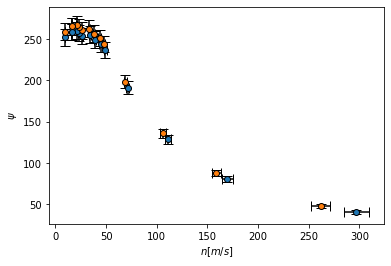

In [14]:
# Figura 4
fig, ax = plt.subplots()
ax.set(ylabel=r'$\psi$', xlabel=r'$n [m/s]$')

#Descarga
ax.errorbar(y=un.nominal_values(b1.psi_m(d_w, De)), x=un.nominal_values(b1.nq_m(d_Q, d_w)), 
            yerr=un.std_devs(b1.psi_m(d_w, De)), xerr=un.std_devs(b1.nq_m(d_Q, d_w)), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'Descarga $\psi_{m}$')

ax.errorbar(y=un.nominal_values(b1.psi_u(d_w, De)), x=un.nominal_values(b1.nq_u(d_Q, d_w)), 
            yerr=un.std_devs(b1.psi_u(d_w, De)), xerr=un.std_devs(b1.nq_u(d_Q, d_w)), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'Descarga $\psi_{u}$')        

#Sucção
ax.errorbar(y=un.nominal_values(b2.psi_m(s_w, De)), x=un.nominal_values(b2.nq_m(s_Q, s_w)), 
            yerr=un.std_devs(b2.psi_m(s_w, De)), xerr=un.std_devs(b2.nq_m(s_Q, s_w)), 
            fmt='o', capsize=5,  markersize=9, markeredgecolor='black', ecolor='black', label=r'Sucção $\psi_{m}$')

ax.errorbar(y=un.nominal_values(b2.psi_u(s_w, De)), x=un.nominal_values(b2.nq_u(s_Q, s_w)), 
            yerr=un.std_devs(b2.psi_u(s_w, De)), xerr=un.std_devs(b2.nq_u(s_Q, s_w)), 
            fmt='o', capsize=5,  markersize=9, markeredgecolor='black', ecolor='black', label=r'Sucção $\psi_{u}$')      
ax.legend()
ax.grid(ls='dotted')
fig.savefig('psi_x_n.pdf', bbox_inches='tight')

In [ ]:
tab = pd.DataFrame({'psi_m':b1.psi_m(w, De), 'psi_u':b1.psi_u(w, De), 'nqm':b1.nq_u(Q, w), 'nqu':b1.nq_u(Q, w)})
print(tab.to_latex())

\begin{tabular}{lllll}
\toprule
{} &       psi\_m &       psi\_u &          nqm &          nqu \\
\midrule
0  &  40.7+/-2.3 &  48.1+/-2.4 &      262+/-9 &      262+/-9 \\
1  &      80+/-4 &      88+/-4 &      159+/-5 &      159+/-5 \\
2  &     129+/-5 &     136+/-5 &  106.3+/-3.0 &  106.3+/-3.0 \\
3  &     191+/-8 &     198+/-8 &   69.1+/-1.9 &   69.1+/-1.9 \\
4  &     237+/-9 &     244+/-9 &   48.1+/-1.3 &   48.1+/-1.3 \\
5  &    244+/-10 &    251+/-10 &   43.5+/-1.1 &   43.5+/-1.1 \\
6  &    249+/-10 &    256+/-10 &   38.1+/-1.0 &   38.1+/-1.0 \\
7  &    255+/-10 &    262+/-10 &   33.2+/-0.9 &   33.2+/-0.9 \\
8  &    253+/-10 &    260+/-10 &   26.0+/-0.7 &   26.0+/-0.7 \\
9  &    257+/-10 &    264+/-10 &   22.8+/-0.6 &   22.8+/-0.6 \\
10 &    260+/-10 &    267+/-10 &   21.1+/-0.6 &   21.1+/-0.6 \\
11 &    258+/-10 &    265+/-10 &   15.9+/-0.4 &   15.9+/-0.4 \\
12 &    258+/-10 &    265+/-10 &   15.9+/-0.4 &   15.9+/-0.4 \\
13 &    252+/-10 &    259+/-10 &  9.20+/-0.24 &  9.20+/-0.24 

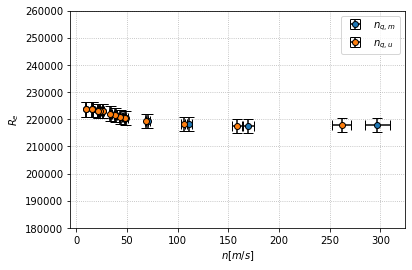

In [ ]:
# Figura 5
viscosidade = 0.893e-6
fig, ax = plt.subplots()
ax.set(ylabel=r'$R_e$', xlabel=r'$n[m/s]$', ylim=(1.8e5,2.6e5))

ax.errorbar(y=un.nominal_values(b1.Re(w, De, viscosidade)), x=un.nominal_values(b1.nq_m(Q, w)), 
            yerr=un.std_devs(b1.Re(w, De, viscosidade)), xerr=un.std_devs(b1.nq_m(Q, w)), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'$n_{q,m}$')

ax.errorbar(y=un.nominal_values(b1.Re(w, De, viscosidade)), x=un.nominal_values(b1.nq_u(Q, w)), 
            yerr=un.std_devs(b1.Re(w, De, viscosidade)), xerr=un.std_devs(b1.nq_u(Q, w)), 
            fmt='o', capsize=5, markeredgecolor='black', ecolor='black', label=r'$n_{q,u}$')      
ax.legend()
ax.grid(ls='dotted')

fig.savefig('Re_x_n.pdf', bbox_inches='tight')

In [ ]:
tab = pd.DataFrame({'Re':b1.Re(w, De, viscosidade), 'nqm':b1.nq_u(Q, w), 'nqu':b1.nq_u(Q, w)})
print(tab.to_latex())

\begin{tabular}{llll}
\toprule
{} &                   Re &          nqm &          nqu \\
\midrule
0  &  (2.178+/-0.025)e+05 &      262+/-9 &      262+/-9 \\
1  &  (2.176+/-0.025)e+05 &      159+/-5 &      159+/-5 \\
2  &  (2.183+/-0.025)e+05 &  106.3+/-3.0 &  106.3+/-3.0 \\
3  &  (2.193+/-0.026)e+05 &   69.1+/-1.9 &   69.1+/-1.9 \\
4  &  (2.206+/-0.026)e+05 &   48.1+/-1.3 &   48.1+/-1.3 \\
5  &  (2.210+/-0.026)e+05 &   43.5+/-1.1 &   43.5+/-1.1 \\
6  &  (2.217+/-0.026)e+05 &   38.1+/-1.0 &   38.1+/-1.0 \\
7  &  (2.221+/-0.026)e+05 &   33.2+/-0.9 &   33.2+/-0.9 \\
8  &  (2.230+/-0.026)e+05 &   26.0+/-0.7 &   26.0+/-0.7 \\
9  &  (2.230+/-0.026)e+05 &   22.8+/-0.6 &   22.8+/-0.6 \\
10 &  (2.230+/-0.026)e+05 &   21.1+/-0.6 &   21.1+/-0.6 \\
11 &  (2.236+/-0.026)e+05 &   15.9+/-0.4 &   15.9+/-0.4 \\
12 &  (2.236+/-0.026)e+05 &   15.9+/-0.4 &   15.9+/-0.4 \\
13 &  (2.236+/-0.026)e+05 &  9.20+/-0.24 &  9.20+/-0.24 \\
\bottomrule
\end{tabular}



In [ ]:
0  &  (2,178+/-0,025)e+05 &      262+/-9 &      262+/-9 \\ \hline
1  &  (2,176+/-0,025)e+05 &      159+/-5 &      159+/-5 \\ \hline
2  &  (2,183+/-0,025)e+05 &  106,3+/-3,0 &  106,3+/-3,0 \\ \hline
3  &  (2,193+/-0,026)e+05 &   69,1+/-1,9 &   69,1+/-1,9 \\ \hline
4  &  (2,206+/-0,026)e+05 &   48,1+/-1,3 &   48,1+/-1,3 \\ \hline
5  &  (2,210+/-0,026)e+05 &   43,5+/-1,1 &   43,5+/-1,1 \\ \hline
6  &  (2,217+/-0,026)e+05 &   38,1+/-1,0 &   38,1+/-1,0 \\ \hline
7  &  (2,221+/-0,026)e+05 &   33,2+/-0,9 &   33,2+/-0,9 \\ \hline
8  &  (2,230+/-0,026)e+05 &   26,0+/-0,7 &   26,0+/-0,7 \\ \hline
9  &  (2,230+/-0,026)e+05 &   22,8+/-0,6 &   22,8+/-0,6 \\ \hline
10 &  (2,230+/-0,026)e+05 &   21,1+/-0,6 &   21,1+/-0,6 \\ \hline
11 &  (2,236+/-0,026)e+05 &   15,9+/-0,4 &   15,9+/-0,4 \\ \hline
12 &  (2,236+/-0,026)e+05 &   15,9+/-0,4 &   15,9+/-0,4 \\ \hline
13 &  (2,236+/-0,026)e+05 &  9,20+/-0,24 &  9,20+/-0,24 \\ \hline